In [26]:
%matplotlib inline
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

from torchsummary import summary
import torch
from torch import nn, optim
from torch.autograd import Variable
import time
from time import strftime, localtime
import copy

# Datasets

Set 1: mixture of randomly generated sines and sine-gaussians within sensible parameters ranges and NO noise.

## Training

- 100 mixed signals + clean/target sources signals

In [2]:
# Parameters

T = 180     # 3 min of data, sampled every 0.1 s
fs = 10
N = T*fs
t = np.linspace(0,T,N)

# These vary..

freq_sin = np.random.uniform(0.0, 1.0, 100)                # frequency of sine wave
phase_shift_sin = np.random.uniform(0.0, 2.0*np.pi, 100)    # phase of sine wave
t0_sg = np.random.uniform(0.0, T, 100)                      # pulse starting time of sine gaussian

# These are fixed

a = 0.1
phi0 = np.pi
f0 = 0.5
tau = 10.0

### Time series

In [4]:
# Time Series

ts_s_train = np.zeros((100,N))
ts_sg_train = np.zeros((100,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(100):
    
    ts_s_train[i,:] = a*np.sin(2*np.pi*freq_sin[i]*t + phase_shift_sin[i]) #+ noise
    ts_sg_train[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_train = ts_s_train + ts_sg_train

(100, 1800)
(100, 1800)
(100, 1800)


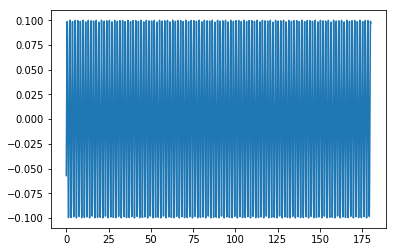

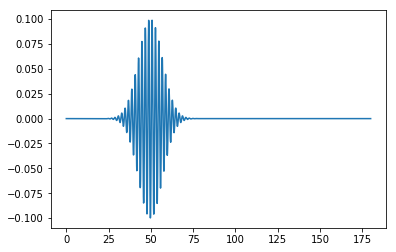

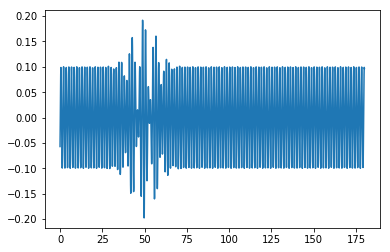

In [5]:
print(ts_s_train.shape)
print(ts_sg_train.shape)
print (ts_mix_train.shape)

# Time series examples

plt.plot(t, ts_s_train[0,:])
plt.show()
plt.plot(t, ts_sg_train[0,:])
plt.show()
plt.plot(t, ts_mix_train[0,:])
plt.show()

## Validation

- 20 mixed signals + clean/target sources signals

### Time series

In [10]:
# Same as training 

ts_s_validation = np.zeros((20,N))
ts_sg_validation = np.zeros((20,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(20):
    
    ts_s_validation[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_validation[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_validation = ts_s_validation + ts_sg_validation

## Testing

- 100 randomly generated useen mixed signals + clean/target sources for evaluation

### Time series

In [12]:
# Time series

ts_s_test = np.zeros((100,N))
ts_sg_test = np.zeros((100,N))

# noise
# noise = np.random.normal(loc=0.0, scale=10.0, size=1000)

for i in range(100):
    
    ts_s_test[i,:] = a*np.sin(2*np.pi*t + phase_shift_sin[i]) #+ noise
    ts_sg_test[i,:] = a*(np.exp(-(t-t0_sg[i])**2/tau**2))*(np.cos(2*np.pi*f0*(t-t0_sg[i])+phi0)) #+ noise
    
    ts_mix_test = ts_s_test + ts_sg_test

# Model

- Architecture is the same for each source. One net per source.
- Basically a convolutional AE with 1D input
- Loss function is the mean square error between the output and the clean target.
- Weights initiated randomly

### Time series

In [30]:
class CDAE(nn.Module):
    
    def __init__(self, in_dim=1800):
        super(CDAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv1d(in_dim, in_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(6, stride=1, return_indices=True),
            nn.Conv1d(300, 300, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool1d(6, stride=1, return_indices=True),
            nn.Conv1d(50, 50, kernel_size=3, stride=1, padding=1)
            
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(50, 200, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            #nn.MaxUnpool1d(5, stride=1)
            nn.ConvTranspose1d(200, in_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            #nn.MaxUnpool1d(5, stride=1)
            nn.ConvTranspose1d(in_dim, in_dim, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded  

In [33]:
#print(summary(CDAE, (1, 1800)))

# Training

In [35]:
# Hyperparameters

num_epochs = 100
batch_size = 100
lr = 0.001

In [39]:
# This net will be trained to separate sine waves from the mixed time series

in_dim = 1800

sine_net = CDAE(in_dim)

#criterion = nn.MSELoss()
optimizer = torch.optim.Adam(sine_net.parameters(), lr=lr)
loss_save = []
epoch = 0

for epoch in range(num_epochs):
    
    epoch += 1
    optimizer.zero_grad()
    loss = 0
    
    for i in range(batch_size):
        
        inputs = torch.from_numpy(ts_mix_train[i, :])
        outputs = sine_net(inputs)
        clean = torch.from_numpy(ts_s_train[i, :])
        loss = loss + torch.nn.functional.mse_loss(outputs, clean)
    
    loss = loss/batch_size
    loss.backward()
    optimizer.step()
    loss_save.append(loss.data[0])
    
    # monitor progress
    if epoch%10==0:
        print('epoch {}, loss {}'.format(epoch, loss.data[0]))
        inputs = torch.from_numpy(ts_mix_train[i, :])
        outputs = sine_net(inputs)
        clean = torch.from_numpy(ts_s_train[i, :])
        
        plt.plot(t, inputs.numpy())
        plt.title('Mixed input')
        plt.show()
        plt.plot(t, outputs.numpy())
        plt.title('Cleaned output')
        plt.show()
        plt.plot(t, clean.numpy())
        plt.title('Target')
        plt.show()

RuntimeError: input has less dimensions than expected